In [118]:


import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median
from skimage.feature import canny
import commonfunctions as cf # this a custom module found the commonfunctions.py
import cv2
import numpy as np
import os


# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt

# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


In [184]:
#bsm allah
# Function to perform the perspective transformation
alpha = 1.0
beta = 0.0
def perspective_transform(img,binary):

    if img is None:
        print(f"Error: Unable to load the image.")
    else:
        # Convert the image to grayscale
        binary_image=0
        if binary==0:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply thresholding to create a binary image
            _, binary_image = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
        else :
            binary_image=img
        # cf.show_images([binary_image])
        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
        print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])

        # Define the destination points for the perspective transformation
        dst_points = np.float32([[0, img.shape[0]], [img.shape[1], img.shape[0]], [0, 0], [img.shape[1], 0]])

        # Calculate the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(sorted_corners.astype(np.float32), dst_points)

        # Apply the perspective transformation to the image
        warped_img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))
        return warped_img
def perspective_transform_2(binary_image,dilated_img):

    if binary_image is None:
        print(f"Error: Unable to load the image.")
    else:
        contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
        print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])
        # Define the destination points for the perspective transformation
        dst_points = np.float32([[0, binary_image.shape[0]], [binary_image.shape[1], binary_image.shape[0]], [0, 0], [binary_image.shape[1], 0]])

        print(sorted_corners)
        print(dst_points)
        # Calculate the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(sorted_corners.astype(np.float32), dst_points)

        # Apply the perspective transformation to the image
        warped_binary_image = cv2.warpPerspective(binary_image, matrix, (binary_image.shape[1], binary_image.shape[0]))
        return warped_binary_image
# # Path to the folder containing images
# folder_path = './sample/'

# # List all files in the folder
# image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
# cnt=0
# # Process each image
# for image_file in image_files:
#     image_path = os.path.join(folder_path, image_file)
#     # print(image_path)
#     if(cnt==0):
#         cf.show_images([perspective_transform(image_path)])
#     cnt+=1

def invert_image(img):
    clone =img
    adjusted_img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
    # cf.show_images([adjusted_img])
    img=perspective_transform(adjusted_img,0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,91, 5)
    thresh_image=255-thresh_image
    trial = perspective_transform(thresh_image,1)
    # cf.show_images([thresh_image])
    transform=perspective_transform(thresh_image,1)
    return transform

def contour_dilation(img) :
     kernel = np.array((1, 10), np.uint8)
     img = cv2.dilate(img, kernel, iterations=10)
    #  cf.show_images([img])
    #  print(img)
     return img
def perspective_transform_2(binary_image,dilated_img):

    if binary_image is None:
        print(f"Error: Unable to load the image.")
    else:
        contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
        print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])
        # Define the destination points for the perspective transformation
        dst_points = np.float32([[0, binary_image.shape[0]], [binary_image.shape[1], binary_image.shape[0]], [0, 0], [binary_image.shape[1], 0]])

        print(sorted_corners)
        print(dst_points)
        # Calculate the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(sorted_corners.astype(np.float32), dst_points)

        # Apply the perspective transformation to the image
        warped_binary_image = cv2.warpPerspective(binary_image, matrix, (binary_image.shape[1], binary_image.shape[0]))
        return warped_binary_image


In [120]:
#detecting Table 
def detectRows(img) : 
        
    # Load the image
    image = img

    # Convert the image to grayscale
    gray = image

    
     # Find contours in the binary image
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours from top to bottom based on y-coordinates of bounding rectangles
    sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])

    # Extract each row based on bounding rectangles' y-coordinates
    row_images = []
    prev_y = -1
    row_img = None

    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # If new row detected baZsed on y-coordinate difference, start a new row image
        if y - prev_y > 50:  # Adjust this threshold according to your table spacing
            if row_img is not None:
                print("Manga")
                row_images.append(row_img)
                show_images([row_img])
            row_img = image[y:y+h, x:x+w].copy()
        else:
            row_img = np.concatenate((row_img, image[y:y+h, x:x+w]), axis=0) if row_img is not None else image[y:y+h, x:x+w].copy()
        
        prev_y = y

    # Append the last row image
    if row_img is not None:
        row_images.append(row_img)

  
    return row_images

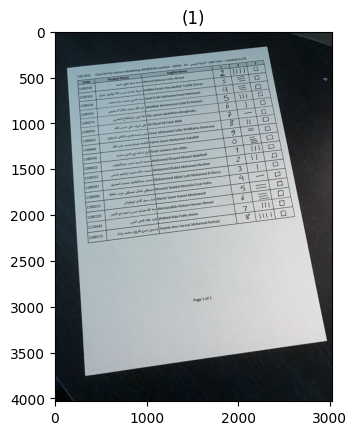

8281
2015
2015


In [121]:
img=cv2.imread('./Samples/12.jpg')
show_images([img])
binary_image=invert_image(img)
test=detectRows(binary_image)
# print(test)
# show_images(test)

In [171]:
img=cv2.imread('./Samples/14.jpg')
transformed_img = perspective_transform(img, 1)
inverted_img=invert_image(transformed_img)
show_images([inverted_img])
# Apply edge detection using Canny edge detector
edges = cv2.Canny(inverted_img, 50, 150, apertureSize=3)

# Perform Hough Line Transform for vertical lines
rho = 1  # 1 pixel
theta = np.pi  # Vertical lines (90 degrees)
threshold = 200  # Adjust this value as needed
min_line_length = 150  # Minimum line length
max_line_gap = 23  # Maximum allowed gap between line segments

lines = cv2.HoughLinesP(edges, rho=rho, theta=theta, threshold=threshold,
                        minLineLength=min_line_length, maxLineGap=max_line_gap)
sorted_lines = sorted(lines, key=lambda line: line[0][0])
print(sorted_lines)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(inverted_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        # need some function to get the most top y and the least top y
xpre1,ypre1,xpre2,ypre2=sorted_lines[0][0]
segs=[100,400]
detected_line=[[],[]]
for line in sorted_lines:
   print(line)
   xcur1,ycur1,xcur2,ycur2=line[0]
   if(xcur1-xpre1>segs[0]):
       detected_line[0]=line
       cv2.line(inverted_img, (xcur1, ycur1), (xcur2, ycur2), (0, 0, 255), 2)
       break
   
xpre1,ypre1,xpre2,ypre2=detected_line[0][0]
for line in sorted_lines:
   print(line)
   xcur1,ycur1,xcur2,ycur2=line[0]
   if(xcur1-xpre1>segs[1]):
       detected_line[1]=line
       cv2.line(inverted_img, (xcur1, ycur1), (xcur2, ycur2), (0, 0, 255), 2)
       break
print(detected_line)
if len(sorted_lines) > 0 and len(detected_line) > 0:
    xs1, ys1, xe1, ye1 = detected_line[0][0]
    xs2, ys2, xe2, ye2 = detected_line[1][0]
    print(xs1,ys1,xe1,ye1)
    print(xs2,ys2,xe2,ye2)
    x_min = min(xe1, xe2, xs1, xs2)
    x_max = max(xe1, xe2, xs1, xs2)
    y_min = min(ye1, ye2, ys1, ys2)
    y_max = max(ye1, ye2, ys1, ys2)
    block = inverted_img[0:4000, x_min:x_max]
    show_images([block])
# # print(len(filtered_lines))
# show_images([inverted_img], ["testing the hog line detection"])
# # line1 = sorted_lines[0]
# x1_line1, y1_line1, x2_line1, y2_line1 = line1[0]
# detected_lines = []  # List to store all lines that meet the condition
# x1_line1, ydasd, xcda, y2das = lines[0][0]
# for curline in lines:
#     xcurs_line1, ycurs_line1, xcure_line1, y2cure_line1 = curline[0]
#     if abs(x1_line1 - xcurs_line1) > 30 : 
#         detected_lines.append(curline)
#         x1_line1 = xcurs_line1

# test_img=inverted_img
# if lines is not None:
#     for line in detected_lines:
#         x1, y1, x2, y2 = line[0]
#         cv2.line(test_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# show_images([test_img], ["testing the hog line detection"])
# final_blocks = []
# if detected_lines:  # Check if any lines were detected
#     for i in range(len(detected_lines) - 1):
#         xs1, ys1, xe1, ye1 = detected_lines[i][0]
#         xs2, ys2, xe2, ye2 = detected_lines[i + 1][0]
        
#         x_min = min(xe1, xe2, xs1, xs2)
#         x_max = max(xe1, xe2, xs1, xs2)
#         y_min = min(ye1, ye2, ys1, ys2)
#         y_max = max(ye1, ye2, ys1, ys2)

#         block = inverted_img[y_min:y_max, x_min:x_max]
#         show_images([block])
#         final_blocks.append(block)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


3
44
1
160
160


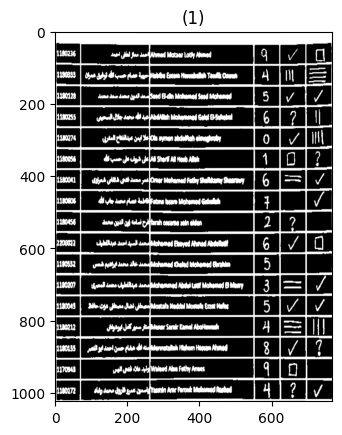

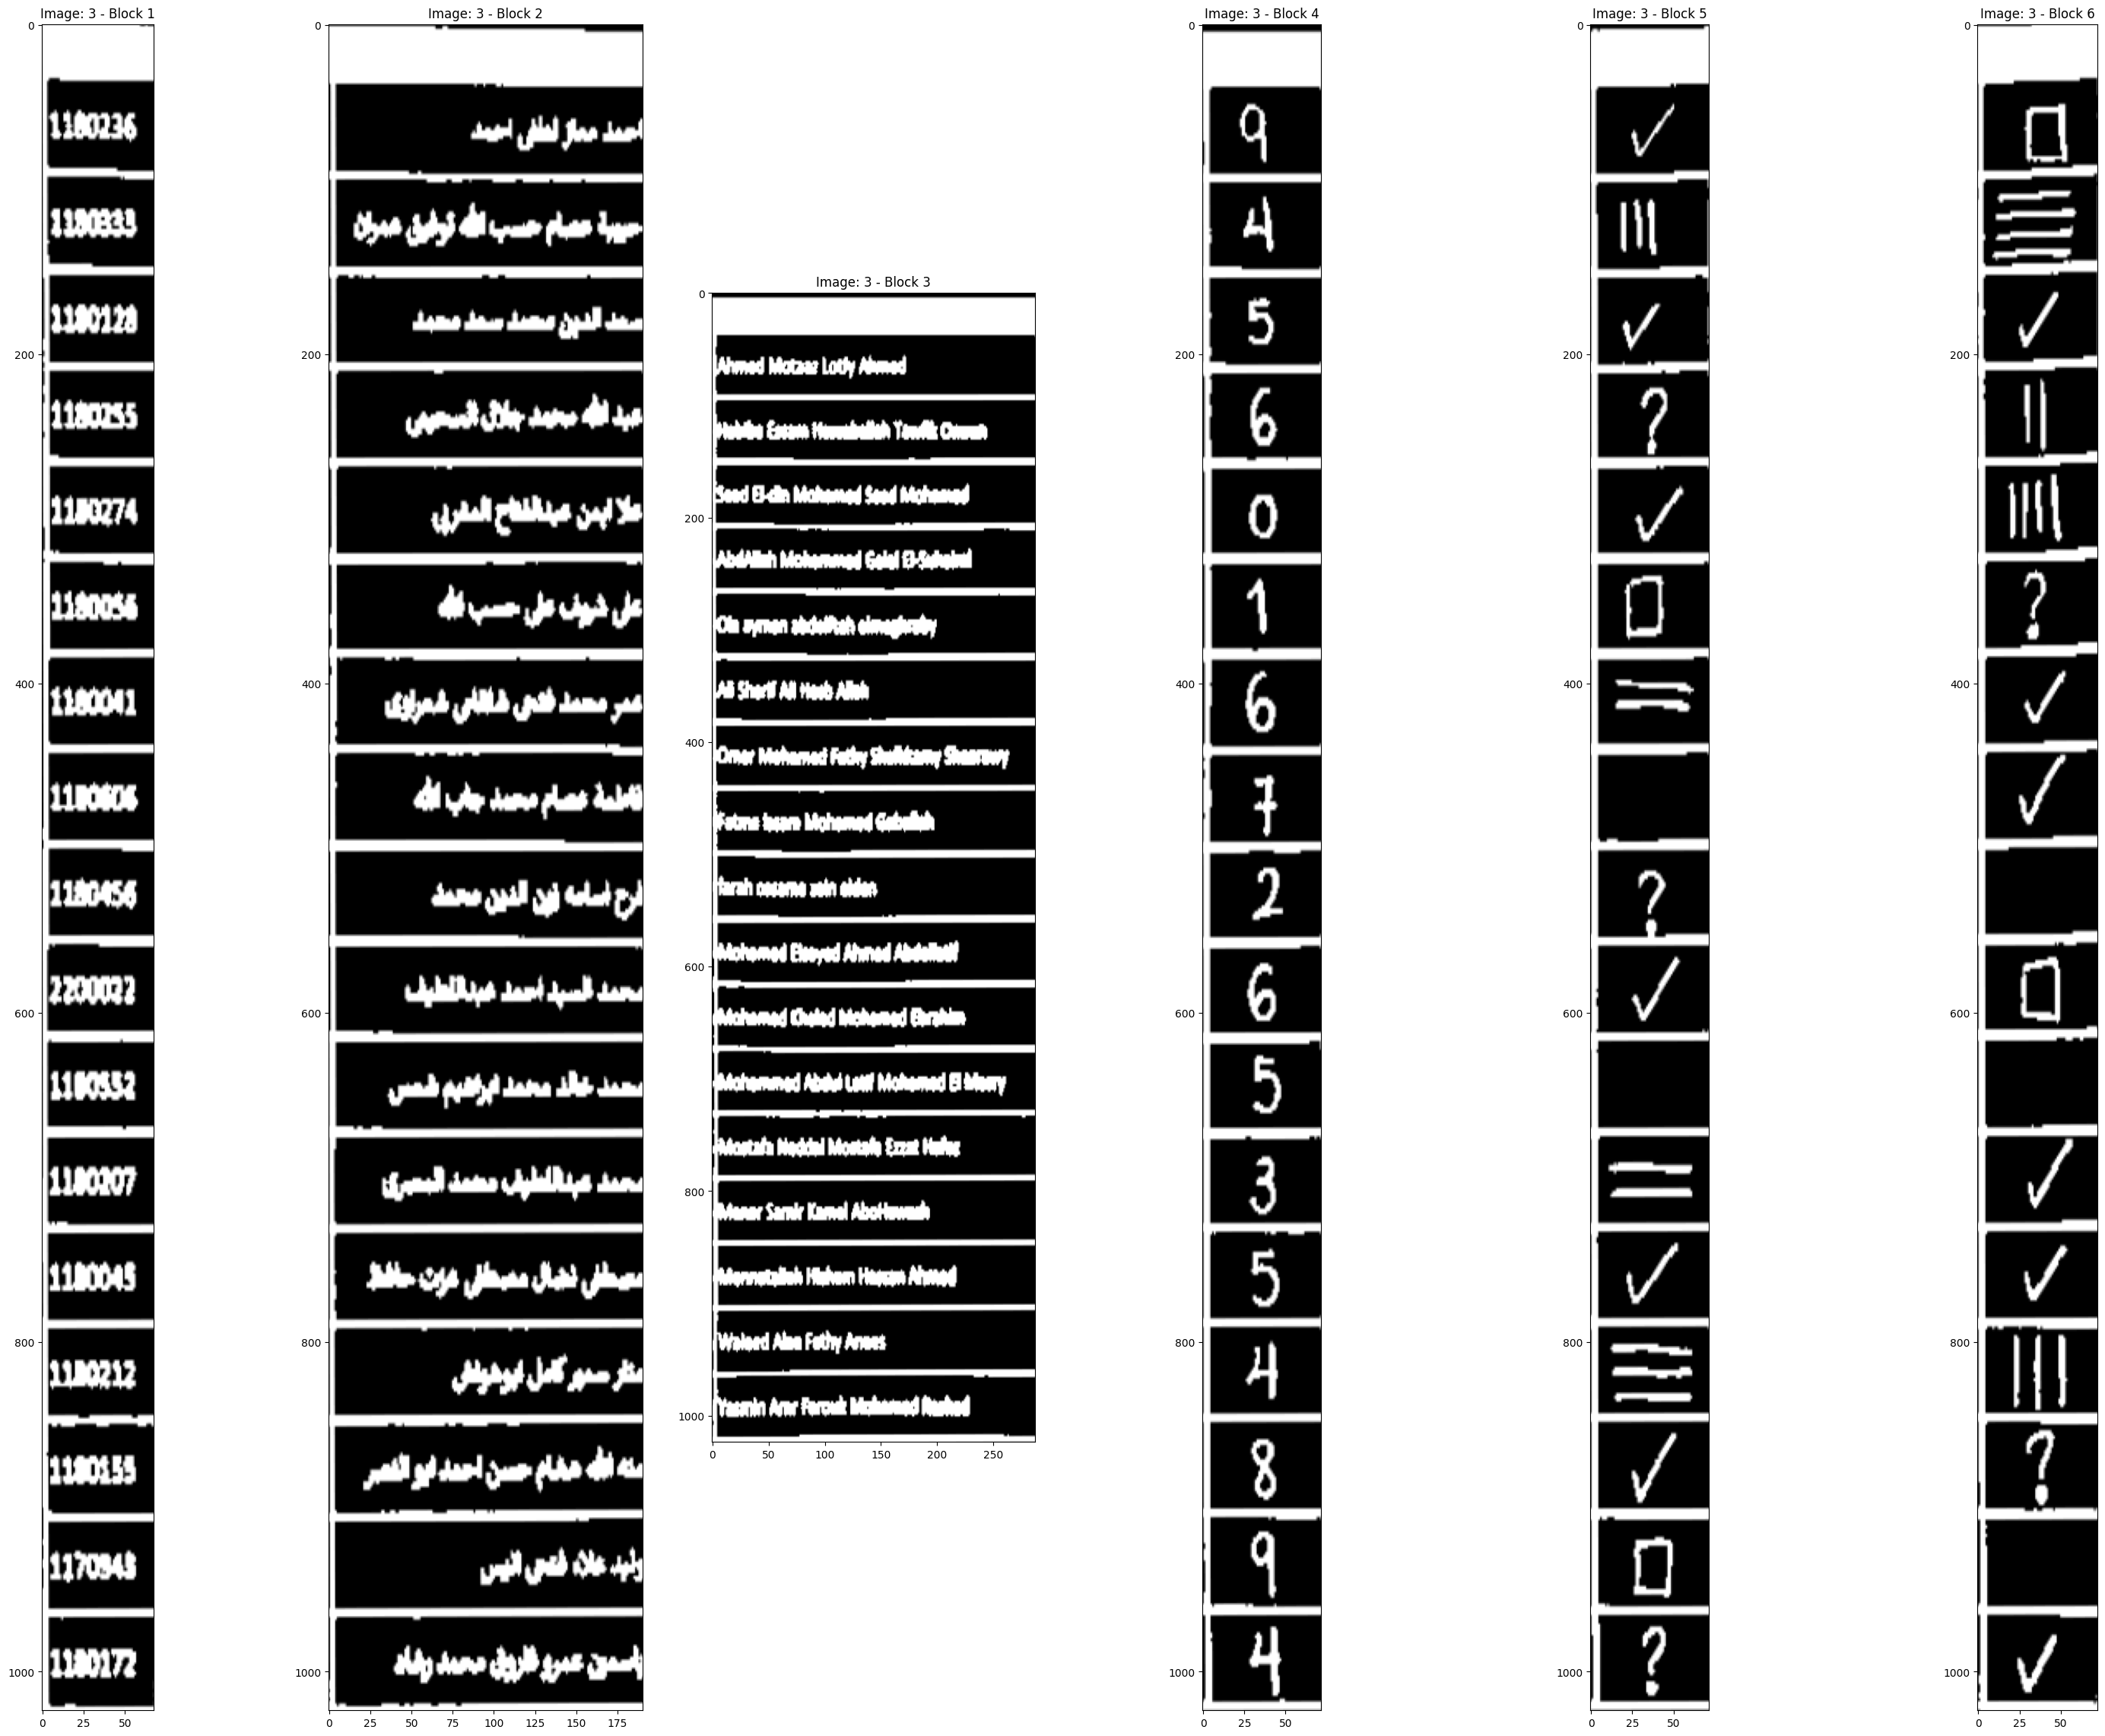

4
18
1
117
117


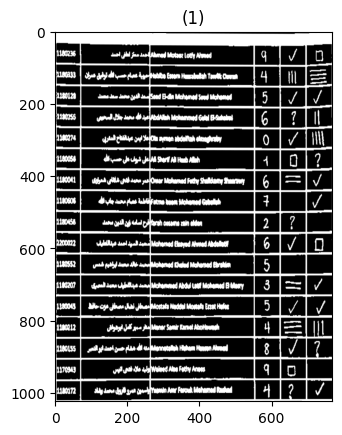

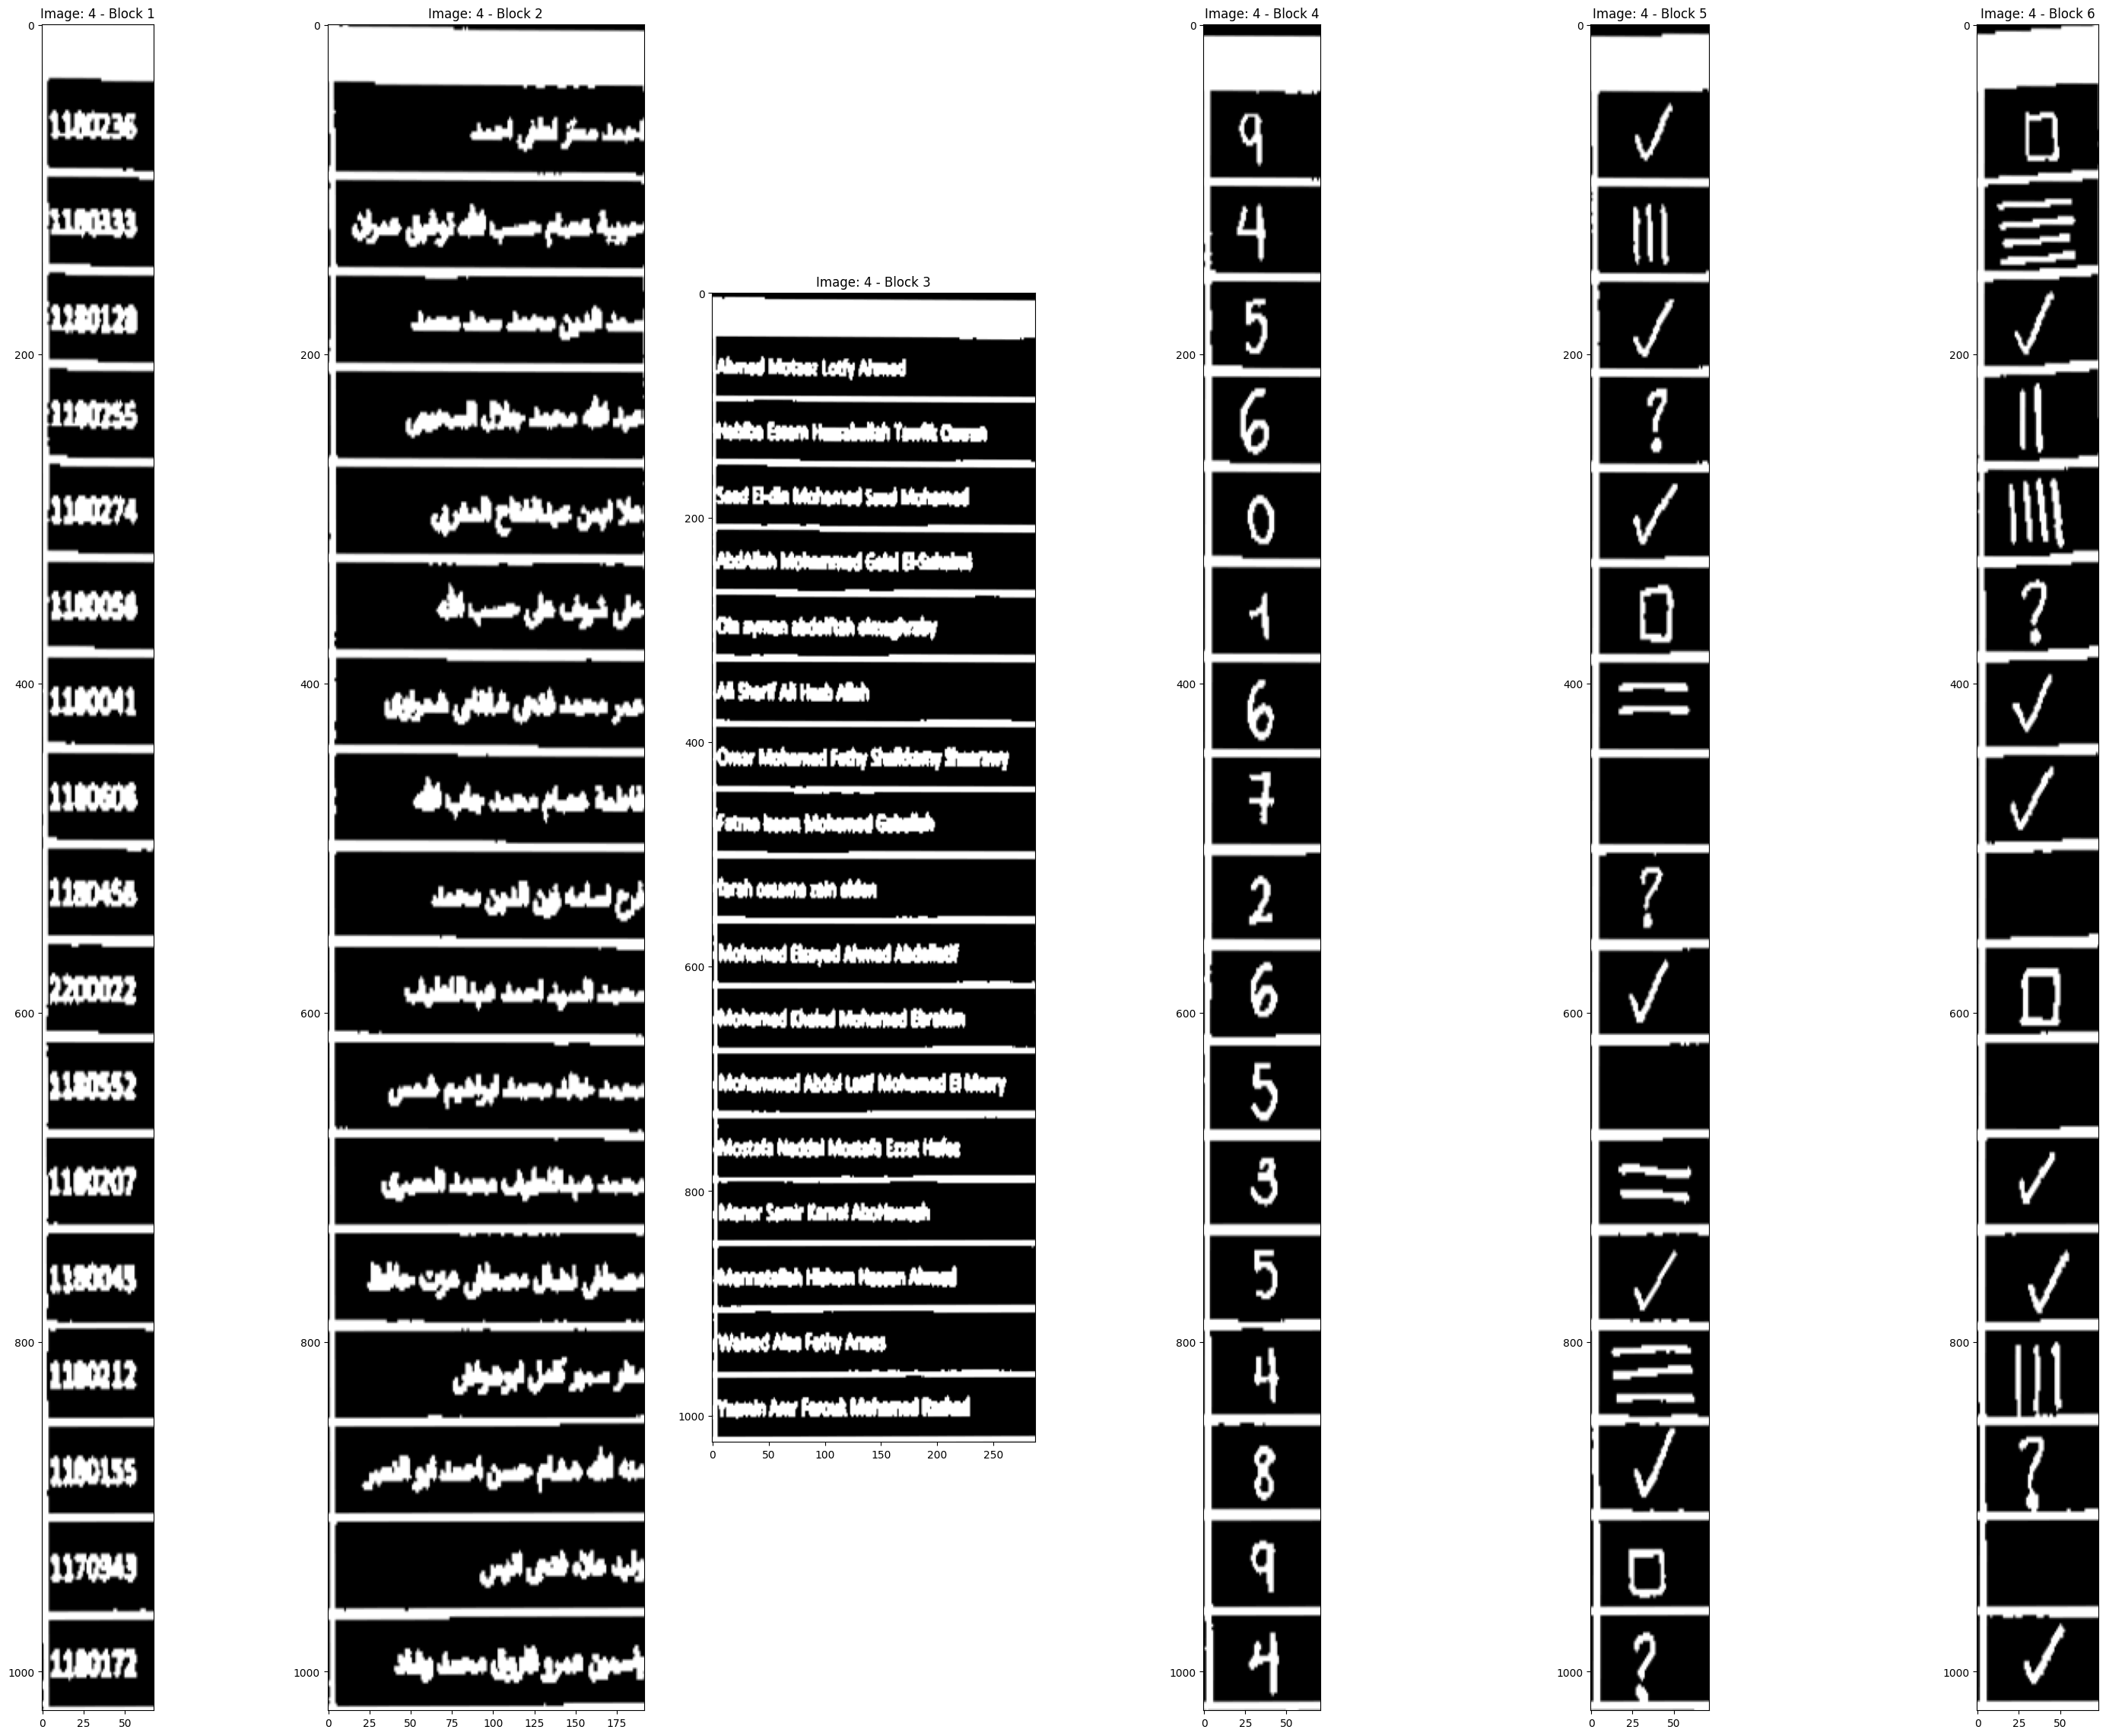

5
9533
2024
10818
10818


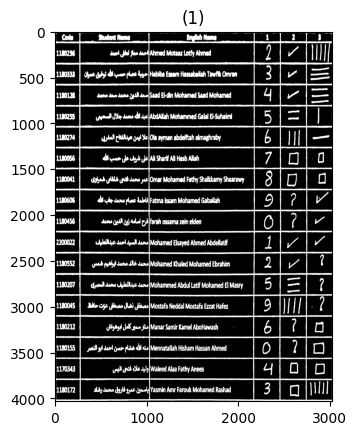

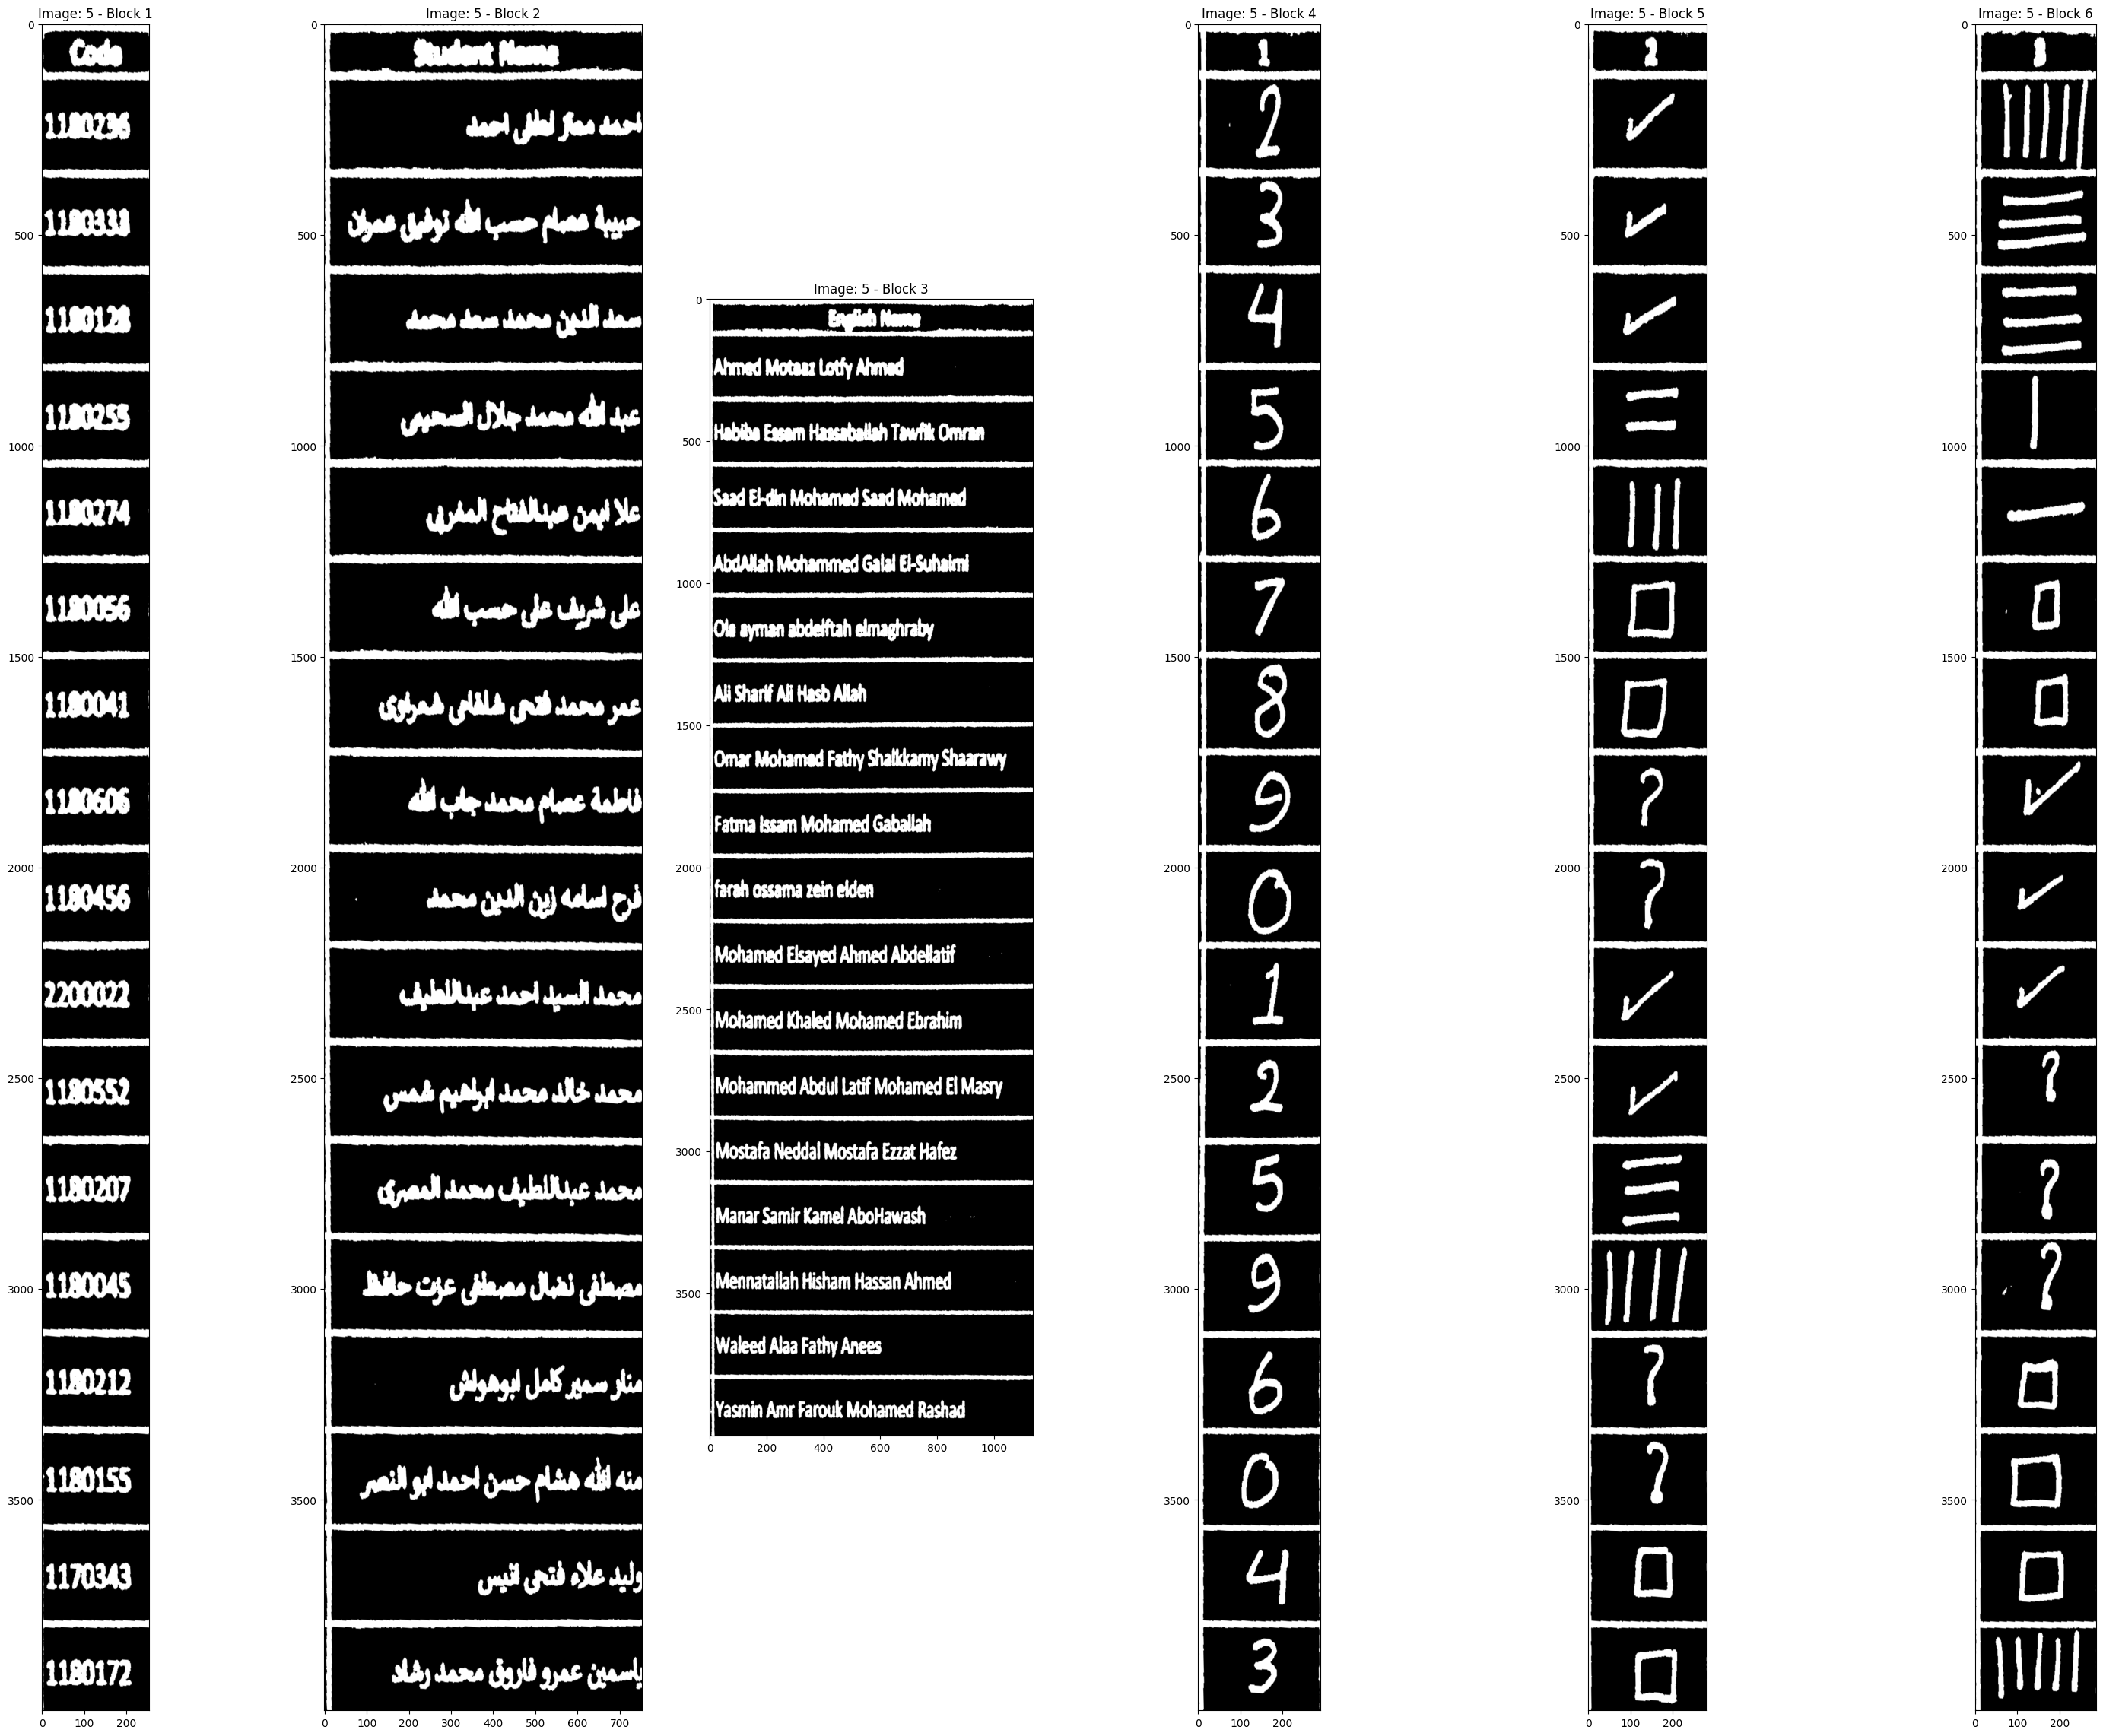

6
13147
1
768
768


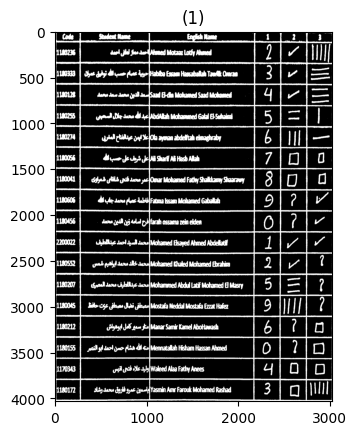

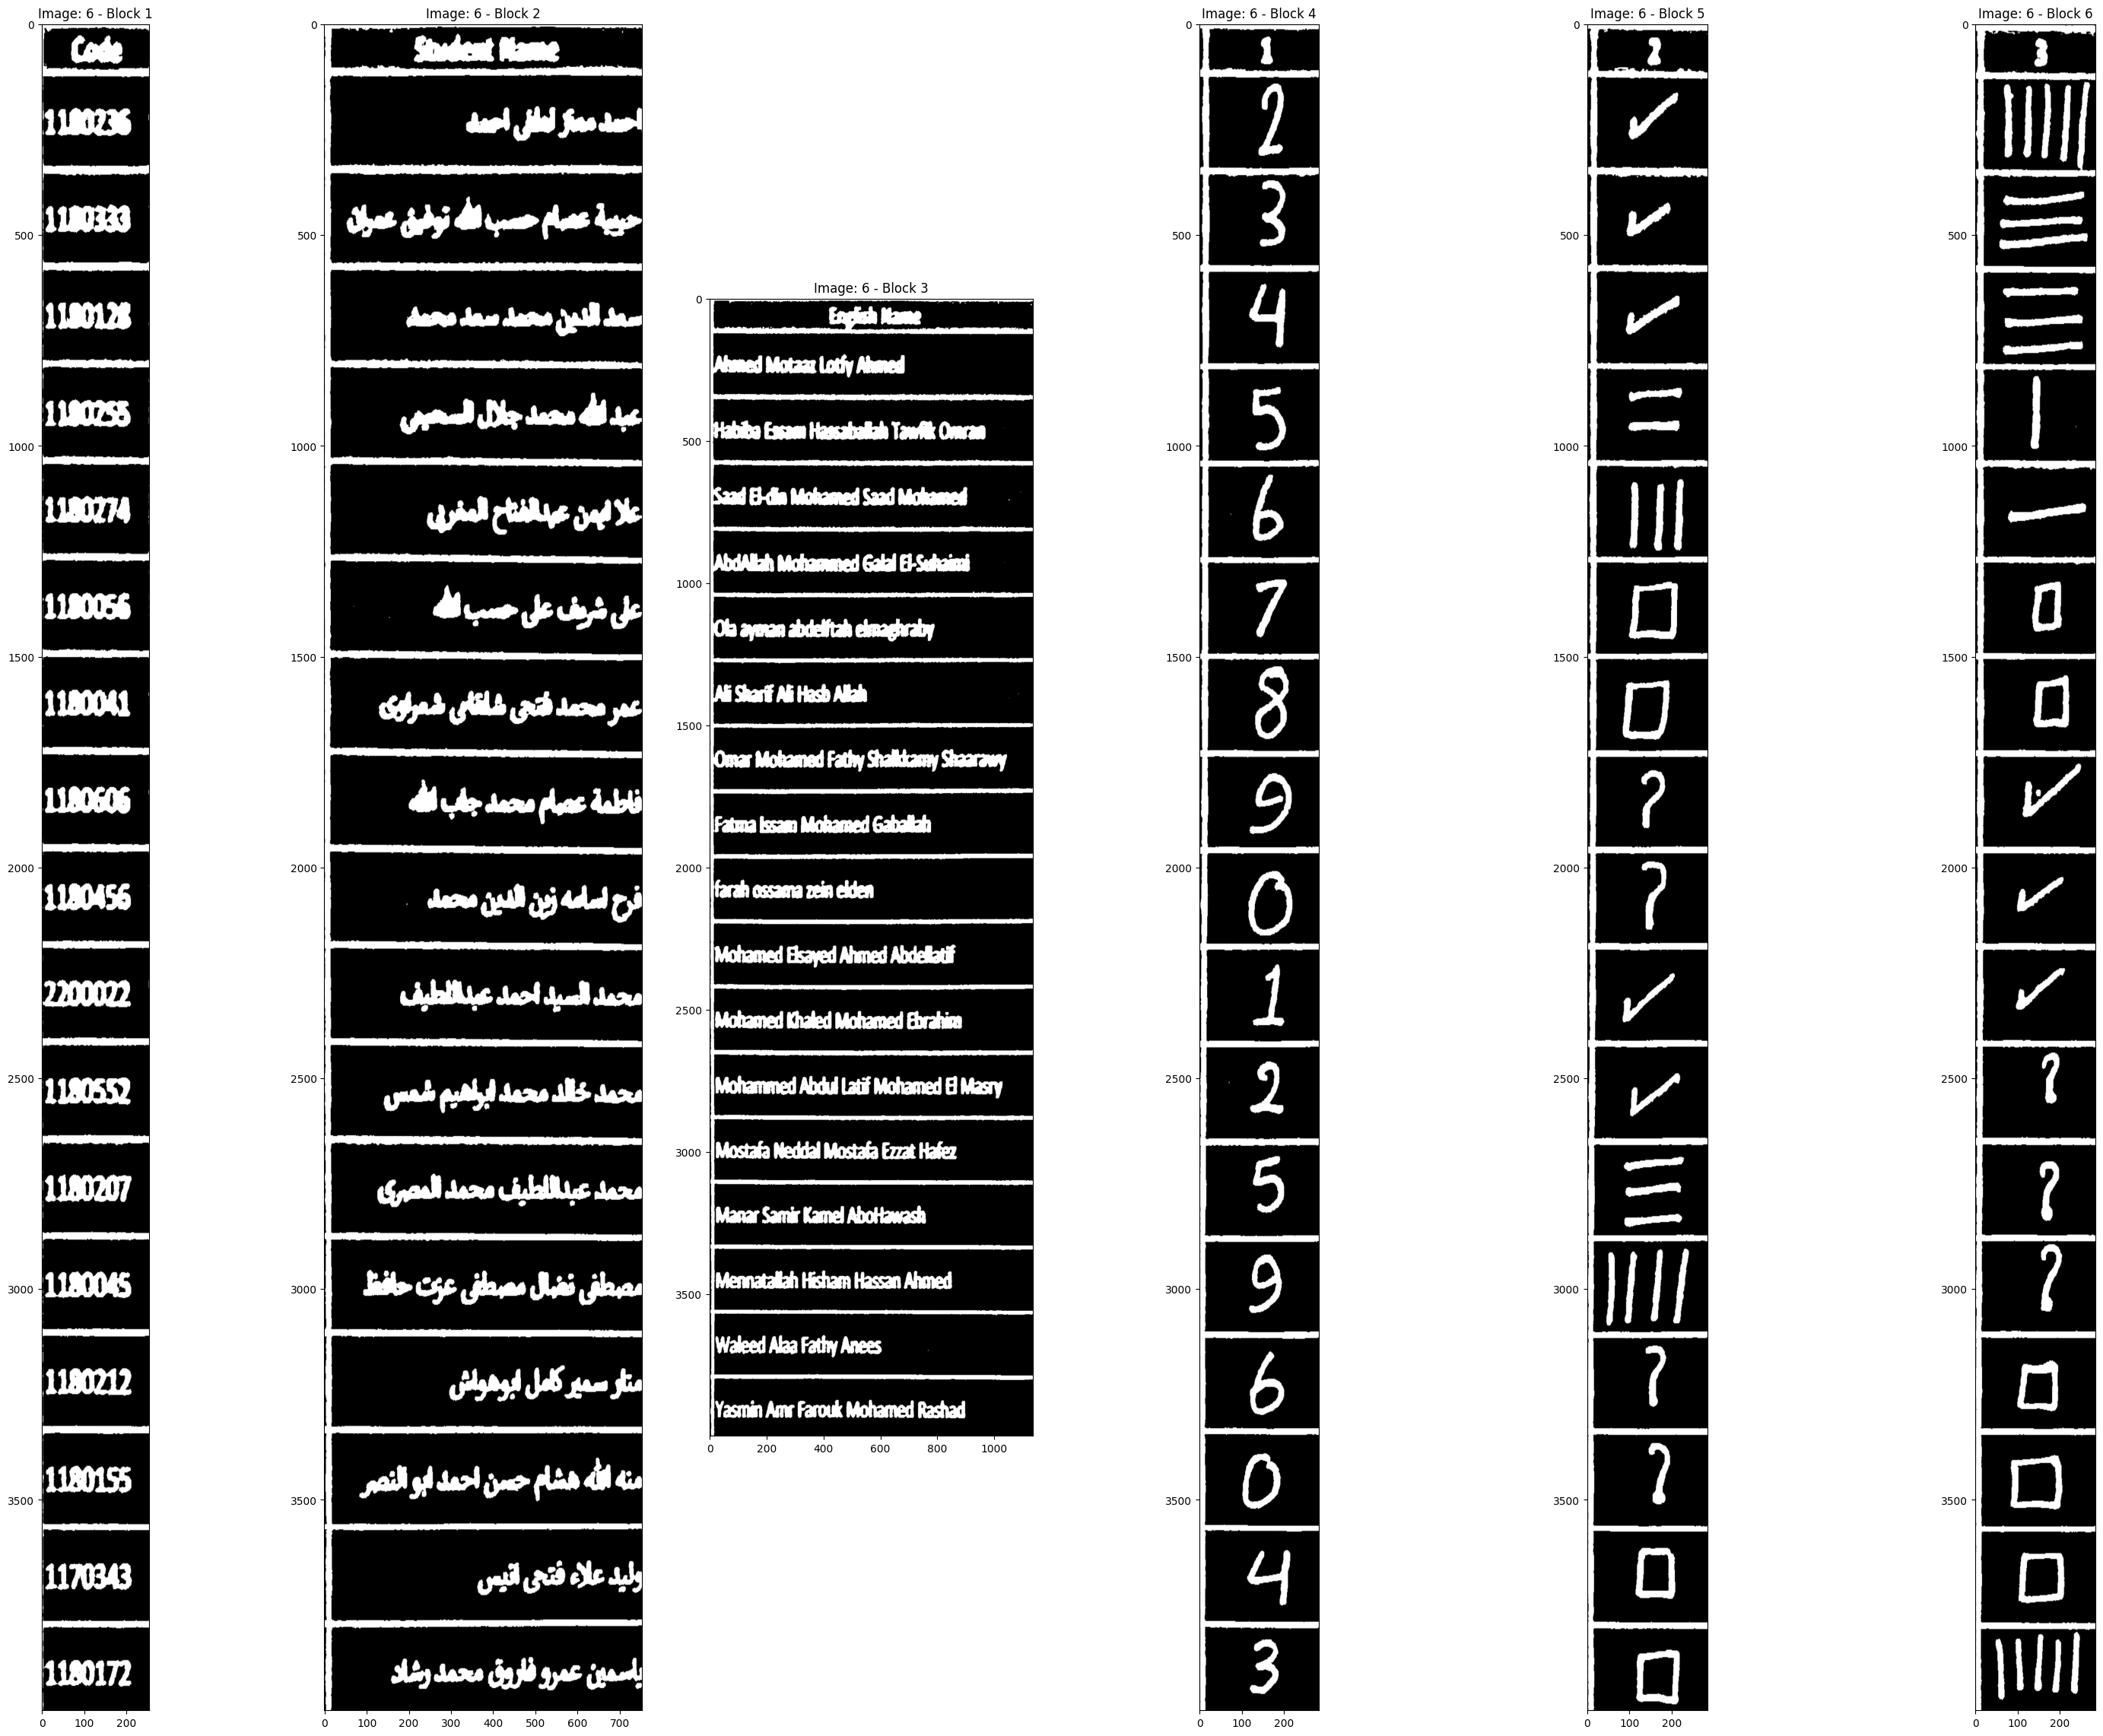

In [189]:
def readImage(imgpath):
    img=cv2.imread(imgpath)
    transformed_img = perspective_transform(img, 0)
    inverted_img=invert_image(transformed_img)
    show_images([inverted_img])
    return inverted_img
def getVerticalLines(inverted_img):
    # Apply edge detection using Canny edge detector
    edges = cv2.Canny(inverted_img, 50, 150, apertureSize=3)
    # Perform Hough Line Transform for vertical lines
    rho = 1  # 1 pixel
    theta = np.pi  # Vertical lines (90 degrees)
    threshold = 260  # Adjust this value as needed
    min_line_length = 160  # Minimum line length
    max_line_gap = 20  # Maximum allowed gap between line segments

    lines = cv2.HoughLinesP(edges, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    sorted_lines = sorted(lines, key=lambda line: line[0][0])
    filtered_lines = [sorted_lines[0]]
    for line in sorted_lines[1:]:
        prev_x = filtered_lines[-1][0][0] 
        cur_x = line[0][0]  

        if cur_x - prev_x >= 20:
            filtered_lines.append(line)  
    return filtered_lines
def getBlocks(lines,width,inverted_img):
    x1=lines[0][0][0]
    idx=0
    for line in lines:
        x2=line[0][0]
        if(x2-x1>width):
            block = inverted_img[0:4000, x1:x2]
            break      
        idx=idx+1
    return [block,idx]
segs=[50,100,200,50,50,50]
def getImageBlocks(filtered_lines,inverted_img):
    idx = 0
    block_images = [] 
    for i in range(len(segs)):
        [block, nwidx] = getBlocks(filtered_lines[idx:], segs[i],inverted_img)
        idx = idx + nwidx
        block_images.append(block)  
    return block_images

samples_dir = './Samples/'
for i in range(8, 16):
    print(i)
    image_path = os.path.join(samples_dir, f"{i}.jpg")
    inverted_img = readImage(image_path)
    filtered_lines = getVerticalLines(inverted_img)
    blocks = getImageBlocks(filtered_lines, inverted_img)
    # Add image number as title for each block set
    block_titles = [f"Image: {i} - Block {j+1}" for j in range(len(blocks))]
    show_images(blocks, block_titles)

